In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# 2. Load and Normalize the Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.1MB/s]


In [5]:
# 3. Define the Model

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)     # flatten input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN().to(device)
print(model)


SimpleNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [6]:
# 4. Define Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:

# 5. Train the Model

epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # --- Evaluation ---
    model.eval()
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

print("✅ Training Complete!")




Epoch [1/10] Train Loss: 0.4941 | Train Acc: 81.97% | Test Loss: 0.4326 | Test Acc: 84.02%
Epoch [2/10] Train Loss: 0.3687 | Train Acc: 86.35% | Test Loss: 0.3885 | Test Acc: 85.45%
Epoch [3/10] Train Loss: 0.3271 | Train Acc: 88.01% | Test Loss: 0.3443 | Test Acc: 87.46%
Epoch [4/10] Train Loss: 0.3025 | Train Acc: 88.72% | Test Loss: 0.3616 | Test Acc: 86.88%
Epoch [5/10] Train Loss: 0.2867 | Train Acc: 89.32% | Test Loss: 0.3396 | Test Acc: 87.71%
Epoch [6/10] Train Loss: 0.2708 | Train Acc: 89.83% | Test Loss: 0.3509 | Test Acc: 87.08%
Epoch [7/10] Train Loss: 0.2552 | Train Acc: 90.38% | Test Loss: 0.3579 | Test Acc: 87.22%
Epoch [8/10] Train Loss: 0.2430 | Train Acc: 90.86% | Test Loss: 0.3410 | Test Acc: 87.85%
Epoch [9/10] Train Loss: 0.2309 | Train Acc: 91.18% | Test Loss: 0.3378 | Test Acc: 88.18%
Epoch [10/10] Train Loss: 0.2204 | Train Acc: 91.72% | Test Loss: 0.3563 | Test Acc: 88.32%
✅ Training Complete!


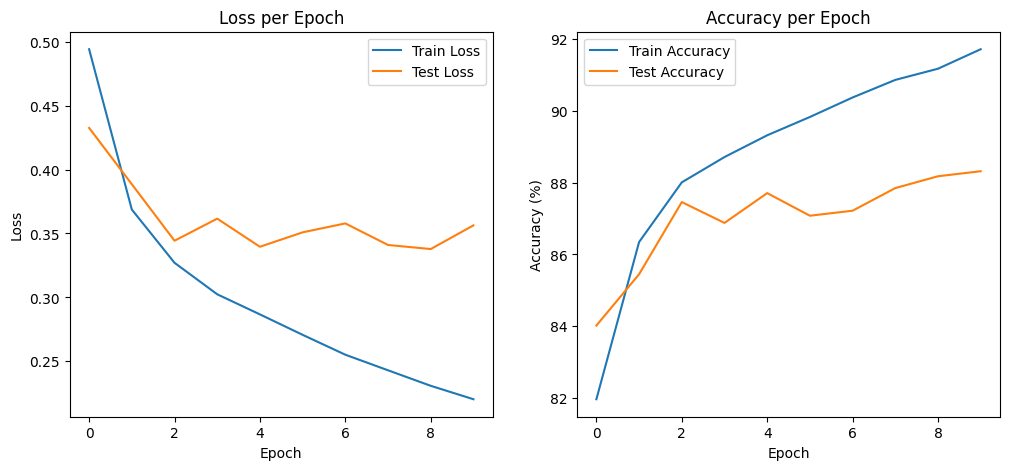

In [8]:

# 6. Plot Loss and Accuracy

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


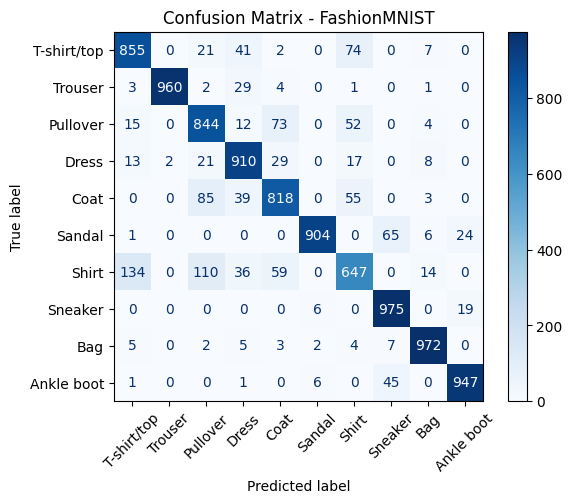

In [9]:
# 7. Confusion Matrix

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - FashionMNIST")
plt.show()



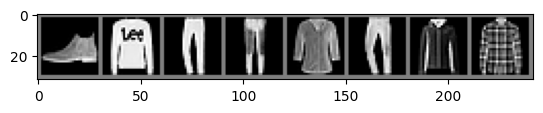

GroundTruth: Ankle boot | Pullover | Trouser | Trouser | Shirt | Trouser |  Coat | Shirt
Predicted:    Ankle boot | Pullover | Trouser | Trouser | Shirt | Trouser |  Coat | Shirt


In [10]:
 # 8. Example Predictions

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images_gpu = images.to(device)
outputs = model(images_gpu)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8]))
print("GroundTruth:", ' | '.join('%5s' % classes[labels[j]] for j in range(8)))
print("Predicted:   ", ' | '.join('%5s' % classes[predicted[j]] for j in range(8)))


In [11]:
# 9. Conclusion
print("\nConclusion:")
print(f"The model achieved a final test accuracy of around {test_accuracies[-1]:.2f}%.")
print("It correctly classifies most categories, though confusion can occur between visually similar items.")
print("Further improvements could be made by using dropout layers, CNNs, or data augmentation.")



Conclusion:
The model achieved a final test accuracy of around 88.32%.
It correctly classifies most categories, though confusion can occur between visually similar items.
Further improvements could be made by using dropout layers, CNNs, or data augmentation.
